# Optimization

In [1]:
import numpy as np
import ga
import pickle
import tensorflow as tf
import csv
import matplotlib.pyplot as plt

In [2]:
# Load the machine learning model and scaler
model = tf.keras.models.load_model(r'E:\ai-power-converter\machine-learning\model_3_512_new_from_selected_model.h5')
csv_file_capacitance = r'E:\ai-power-converter\dataset\capacitor_lookup_table.csv'  # Replace 'your_csv_file.csv' with the path to your CSV file
csv_file_inductance = r'E:\ai-power-converter\dataset\inductor_lookup_table.csv'
# Define constraint values
Vol_lim = 7e-6
Delta_Vo_percent_lim = 1
Delta_IL_percent_lim = 0.1

# Genetic algorithm parameters
sol_per_pop = 8
num_parents_mating = 4
pop_size = (sol_per_pop, 3)  # We have 3 variables: fs, L, C
num_generations = 100
# Generate initial population
L_range = (30e-6, 2000e-6)  # Range for L
C_range = (30e-6, 200e-6)   # Range for C
fsw_range = (20e3, 200e3)    # Range for fsw
num_values = sol_per_pop

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3

# Define mutation ranges for each parameter
mutation_ranges = [(30e-6, 100e-6), (20e-6, 100e-6), (10, 1000)]

# # Create arrays of discrete L, C, and fsw values within the specified ranges
L_values = np.linspace(L_range[0], L_range[1], num=num_values)
C_values = np.linspace(C_range[0], C_range[1], num=num_values)

# Round the values to the desired number of decimal places
L_values = np.around(L_values, decimals=6)
C_values = np.around(C_values, decimals=6)

fsw_values = np.linspace(fsw_range[0], fsw_range[1], num=num_values, dtype=int)

initial_population = np.column_stack((L_values, C_values, fsw_values))

# Function

## Scaling

In [3]:
def scale_input_values(input_values):

    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array

    # Scale L
    input_values_scaled[0] = (input_values[0] - L_min) / (L_max - L_min)

    # Scale C
    input_values_scaled[1] = (input_values[1] - C_min) / (C_max - C_min)

    # Scale fsw
    input_values_scaled[2] = (input_values[2] - fsw_min) / (fsw_max - fsw_min)
    # Make predictions using the model

    # Reshape the input data to match the expected shape of the model
    input_values_reshaped = input_values_scaled.reshape((1, -1))

    return input_values_reshaped

## Calculate Fitness

In [4]:

def calculate_fitness(individual):

    input_values_scaled = scale_input_values(individual)

    prediction = model.predict(input_values_scaled, verbose=0)
    
    # Extract predictions from the model output
    P_l_s1 = prediction[0][2]
    P_l_s2 = prediction[0][3]
    P_l_C = prediction[0][4]
    P_l_L_Cu = prediction[0][5]
    
    # Calculate the objective function value based on the given equation
    objective_value = P_l_s1 + P_l_s2 + P_l_L_Cu + P_l_C
    
    return objective_value


## Search Volume

### Capacitance

In [5]:
def search_volume_capacitance(capacitance, csv_file):
    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        capacitance_values = []
        volume_values = []
        for row in reader:
            capacitance_values.append(float(row['Capacitance']))
            volume_values.append(float(row['Total Volume']))
        
        # Find the index of the nearest capacitance value
        nearest_idx = np.abs(np.array(capacitance_values) - capacitance).argmin()
        nearest_capacitance = capacitance_values[nearest_idx]
        nearest_volume = volume_values[nearest_idx]
        
        return nearest_capacitance, nearest_volume

### Inductance

In [6]:

def search_volume_inductance(inductance, csv_file):
    with open(csv_file, mode='r') as file:
        reader = csv.DictReader(file)
        inductance_values = []
        volume_values = []
        for row in reader:
            inductance_values.append(float(row['Inductance']))
            volume_values.append(float(row['Volume']))
        
        # Find the index of the nearest inductance value
        nearest_idx = np.abs(np.array(inductance_values) - inductance).argmin()
        nearest_inductance = inductance_values[nearest_idx]
        nearest_volume = volume_values[nearest_idx]
        
        return nearest_inductance, nearest_volume


## Check Constraints

In [7]:

# Define the constraints function
def check_constraints(individual):
    L = individual[0]
    C = individual[1]
    fs = individual[2]
    
    # Define the constraint values
    nearest_C, Vol_C  = search_volume_capacitance(C, csv_file_capacitance) # Define Vol_L based on your problem-specific requirements
    nearest_L, Vol_L  = search_volume_inductance(L, csv_file_inductance)

    # Prepare input values for prediction
    input_values = np.array([L, C, fs])
    # Apply Min-Max normalization separately for each input feature
    input_values_scaled = scale_input_values(input_values)

    prediction = model.predict(input_values_scaled, verbose = 0)
    # Extract predictions from the model output
    Delta_IL_percent = prediction[0][0]
    Delta_Vo_percent = prediction[0][1]

    # Check if constraints are satisfied
    constraint1 = Vol_C + Vol_L  <= Vol_lim
    constraint2 = Delta_Vo_percent <= Delta_Vo_percent_lim
    constraint3 = Delta_IL_percent <= Delta_IL_percent_lim
    
    # return constraint1 and constraint2 and constraint3
    return constraint1 and constraint2 and constraint3  

## Check prediction

In [8]:
def check_prediction(val):
    input_values_scaled = scale_input_values(val)

    prediction = model.predict(input_values_scaled, verbose = 0)
    return prediction

## Generate feasible solution

In [9]:
def generate_feasible_solution(L_range, C_range, fsw_range):
    while True:
        # Generate random values for L, C, and fsw within the specified ranges
        new_L = np.random.uniform(L_range[0], L_range[1])
        new_C = np.random.uniform(C_range[0], C_range[1])
        new_fsw = np.random.randint(fsw_range[0], fsw_range[1] + 1)

        # Check if the generated solution satisfies the constraints
        if check_constraints([new_L, new_C, new_fsw]):
            return [new_L, new_C, new_fsw]


# Genetic Algorithm

Generation :  0


Fitness
[8.553675  5.3158712 5.9947777 6.5669346 7.5522013 8.505006  9.198209
 8.820727 ]
Population [[3.00000e-05 3.00000e-05 2.00000e+04]
 [3.11000e-04 5.40000e-05 4.57140e+04]
 [5.93000e-04 7.90000e-05 7.14280e+04]
 [8.74000e-04 1.03000e-04 9.71420e+04]
 [1.15600e-03 1.27000e-04 1.22857e+05]
 [1.43700e-03 1.51000e-04 1.48571e+05]
 [1.71900e-03 1.76000e-04 1.74285e+05]
 [2.00000e-03 2.00000e-04 2.00000e+05]]
Best result: 5.3158712
Best solution index: 1
Best solution: [3.1100e-04 5.4000e-05 4.5714e+04]
Best solutions array: [array([3.1100e-04, 5.4000e-05, 4.5714e+04])]
Best fitness: 5.3158712
Parents
[[8.90000e-04 5.50000e-05 1.01417e+05]
 [1.97200e-03 6.10000e-05 5.26920e+04]
 [1.47300e-03 8.20000e-05 1.21035e+05]
 [1.36300e-03 7.50000e-05 1.87726e+05]]
Crossover
[[8.90000e-04 6.10000e-05 5.26920e+04]
 [1.97200e-03 8.20000e-05 1.21035e+05]
 [1.47300e-03 7.50000e-05 1.87726e+05]
 [1.36300e-03 5.50000e-05 1.01417e+05]]
Mutation
[[8.79000e-04 3.00000e-05 5.22130e+04]
 [1.98900e-03 2.00

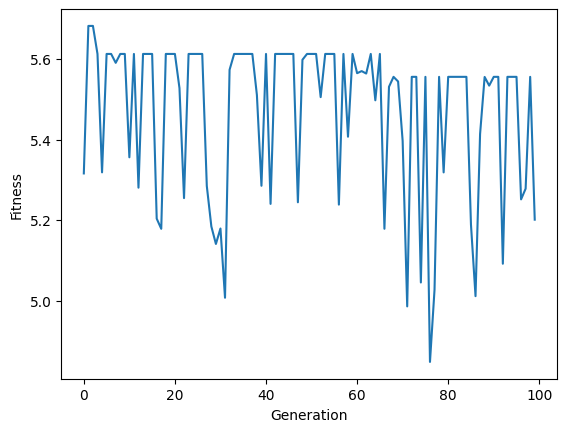

In [10]:

# Genetic Algorithm optimization
best_outputs = []
best_solutions = []  # Store the best solution for each generation
best_fitnesses = []  # Store the best fitness for each generation
new_population = initial_population

for generation in range(num_generations):
    print("Generation : ", generation)
    
    # Measuring the fitness of each chromosome in the population.
    fitness_values = []
    delta_IL_percent_values = []
    delta_Vo_percent_values = []
    for individual in new_population:
        fitness_value = calculate_fitness(individual)
        fitness_values.append(fitness_value)

    fitness = np.array(fitness_values)

    
    print("Fitness")
    print(fitness)

    # best_outputs.append(np.min(fitness))
    # print("Best result : ", np.min(fitness))
    # print("Population: ", new_population)
    # # Find the index of the best solution in this generation
    # best_solution_idx = np.argmin(fitness)
    # print("this is best_solution_idx: ", best_solution_idx )
    # best_solution = new_population[best_solution_idx]
    # best_solutions.append(best_solution)
    # print("array best solutions",best_solutions)
    # best_fitness = fitness[best_solution_idx]
    # best_fitnesses.append(best_fitness)
    # print("Best solution : ", best_solution)
    # print("Best fitness : ", best_fitness)
    print("Population", new_population)
    best_outputs.append(np.min(fitness))
    print("Best result:", np.min(fitness))

    # Find the index of the best solution in this generation
    best_solution_idx = np.argmin(fitness)
    print("Best solution index:", best_solution_idx)

    # Retrieve the best solution from the population
    best_solution = new_population[best_solution_idx].copy()  # Copy the best solution
    print("Best solution:", best_solution)

    # Append the current best solution to the list of best solutions
    best_solutions.append(best_solution.copy())  # Append a copy of the best solution
    print("Best solutions array:", best_solutions)

    # Append the corresponding fitness value to the list of best fitnesses
    best_fitness = fitness[best_solution_idx]
    best_fitnesses.append(best_fitness)
    print("Best fitness:", best_fitness)



    # Check and enforce constraints
    for i in range(sol_per_pop):
        if not check_constraints(new_population[i]):
            # Regenerate individual until it satisfies the constraints
            while not check_constraints(new_population[i]):
                # Generate all possible values within the specified range with the desired increment
                L_values_all = np.arange(L_range[0], L_range[1] + 1e-6, 1e-6)
                C_values_all = np.arange(C_range[0], C_range[1] + 1e-6, 1e-6)
                # Generate new random values for fsw, L, and C
                new_L = np.random.choice(L_values_all, 1, replace=False)
                new_C = np.random.choice(C_values_all, 1, replace=False)
                new_fsw = np.random.randint(fsw_range[0], fsw_range[1] + 1, size=1)

                new_population[i] = [new_L[0], new_C[0], new_fsw[0]]
                # new_population[i] = generate_feasible_solution(L_range, C_range, fsw_range)


    # Selecting the best parents in the population for mating.
    parents = ga.select_mating_pool(new_population, fitness, num_parents_mating)
    print("Parents")
    print(parents)

    # Generating next generation using crossover.
    offspring_crossover = ga.crossover(parents, offspring_size=(pop_size[0]-parents.shape[0], 3))
    print("Crossover")
    print(offspring_crossover)

    # Adding some variations to the offspring using mutation.
    # offspring_mutation = ga.mutation(offspring_crossover, 2)
    # offspring_mutation = ga.mutation(offspring_crossover, mutation_ranges, 1)
    offspring_mutation = ga.mutation(offspring_crossover, mutation_ranges, L_range, C_range, fsw_range, 2)
    print("Mutation")
    print(offspring_mutation)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

# Getting the best solution after iterating finishing all generations.
# At first, the fitness is calculated for each solution in the final generation.
fitness_values = []

for individual in new_population:
    fitness_value= calculate_fitness(individual)
    fitness_values.append(fitness_value)

fitness = np.array(fitness_values)


# Then return the index of that solution corresponding to the best fitness.
best_match_idx = np.where(fitness == np.min(fitness))

print("Best solution : ", new_population[best_match_idx, :])
print("Best solution fitness : ", fitness[best_match_idx])


plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.show()

In [11]:
print(best_solutions)
print(len(best_solutions))

[array([3.1100e-04, 5.4000e-05, 4.5714e+04]), array([8.7900e-04, 3.0000e-05, 5.2213e+04]), array([8.7900e-04, 3.0000e-05, 5.2213e+04]), array([9.7800e-04, 7.3000e-05, 5.0729e+04]), array([9.7700e-04, 1.8000e-04, 5.2065e+04]), array([9.7800e-04, 7.3000e-05, 5.0729e+04]), array([9.7800e-04, 7.3000e-05, 5.0729e+04]), array([9.5100e-04, 5.6000e-05, 4.7901e+04]), array([9.7800e-04, 7.3000e-05, 5.0729e+04]), array([9.7800e-04, 7.3000e-05, 5.0729e+04]), array([9.1000e-04, 1.4600e-04, 5.1433e+04]), array([9.7800e-04, 7.3000e-05, 5.0729e+04]), array([9.0200e-04, 1.5800e-04, 5.2618e+04]), array([9.7800e-04, 7.3000e-05, 5.0729e+04]), array([9.7800e-04, 7.3000e-05, 5.0729e+04]), array([9.7800e-04, 7.3000e-05, 5.0729e+04]), array([8.6400e-04, 1.6900e-04, 5.2623e+04]), array([8.5100e-04, 2.0000e-04, 5.4056e+04]), array([9.7800e-04, 7.3000e-05, 5.0729e+04]), array([9.7800e-04, 7.3000e-05, 5.0729e+04]), array([9.7800e-04, 7.3000e-05, 5.0729e+04]), array([8.1100e-04, 1.3800e-04, 5.1053e+04]), array([8.

In [12]:
# Print the best solutions for each generation
print("Best solutions for each generation:")
for i, (solution, fitness) in enumerate(zip(best_solutions, best_fitnesses)):
    print("Generation", i, ":", "Fitness:", fitness)
    print("Solution (L, C, fsw):", solution)
    
    # Calculate additional information for the current solution
    L = solution[0]
    C = solution[1]
    fs = solution[2]
    nearest_C, Vol_C = search_volume_capacitance(C, csv_file_capacitance)
    nearest_L, Vol_L = search_volume_inductance(L, csv_file_inductance)
    
    # Prepare input values for prediction
    input_values = np.array([L, C, fs])
    input_values_scaled = np.zeros_like(input_values, dtype=float)
    input_values_scaled[0] = (input_values[0] - L_min) / (L_max - L_min)
    input_values_scaled[1] = (input_values[1] - C_min) / (C_max - C_min)
    input_values_scaled[2] = (input_values[2] - fsw_min) / (fsw_max - fsw_min)
    input_values_reshaped = input_values_scaled.reshape((1, -1))
    
    # Make predictions using the model
    prediction = model.predict(input_values_reshaped, verbose=0)
    Delta_IL_percent = prediction[0][0]
    Delta_Vo_percent = prediction[0][1]
    
    print("Volume L:", Vol_L)
    print("Volume C:", Vol_C)
    print("Delta Vo percent:", Delta_Vo_percent)
    print("Delta Il percent:", Delta_IL_percent)
    print()  # Add a blank line for readability


Best solutions for each generation:
Generation 0 : Fitness: 5.3158712
Solution (L, C, fsw): [3.1100e-04 5.4000e-05 4.5714e+04]


Volume L: 2.0828406321502e-06
Volume C: 4.129e-06
Delta Vo percent: 1.1949697
Delta Il percent: 0.2940497

Generation 1 : Fitness: 5.682036
Solution (L, C, fsw): [8.7900e-04 3.0000e-05 5.2213e+04]
Volume L: 2.0828406321502e-06
Volume C: 1.564e-06
Delta Vo percent: 0.7001853
Delta Il percent: 0.08880207

Generation 2 : Fitness: 5.682036
Solution (L, C, fsw): [8.7900e-04 3.0000e-05 5.2213e+04]
Volume L: 2.0828406321502e-06
Volume C: 1.564e-06
Delta Vo percent: 0.7001853
Delta Il percent: 0.08880207

Generation 3 : Fitness: 5.6124835
Solution (L, C, fsw): [9.7800e-04 7.3000e-05 5.0729e+04]
Volume L: 2.0828406321502e-06
Volume C: 4.887e-06
Delta Vo percent: 0.68945026
Delta Il percent: 0.07987016

Generation 4 : Fitness: 5.318537
Solution (L, C, fsw): [9.7700e-04 1.8000e-04 5.2065e+04]
Volume L: 2.0828406321502e-06
Volume C: 3.678e-06
Delta Vo percent: 7.757016
Delta Il percent: 0.23590413

Generation 5 : Fitness: 5.6124835
Solution (L, C, fsw): [9.7800e-04 7.3000e-05 5.0729e+04]
Volume L:

## Ranking

Sorted Solutions:
Rank: 1
Solution (L, C, fsw): [8.4400e-04 1.7400e-04 3.4365e+04]
Fitness: 4.8479986
Volume L: 2.0828406321502e-06
Volume C: 3.659e-06
Delta Vo: 7.4245963
Delta IL: 0.26079193
P_l_s1:  1.8421617
P_l_s2:  1.8387326
P_l_C:  0.036847852
P_l_L_Cu:  1.1302564
Losses Total: 4.8479986

Rank: 2
Solution (L, C, fsw): [7.7100e-04 1.9500e-04 4.9643e+04]
Fitness: 4.985826
Volume L: 2.0828406321502e-06
Volume C: 5.212e-06
Delta Vo: 9.297308
Delta IL: 0.250979
P_l_s1:  1.9345102
P_l_s2:  1.9401898
P_l_C:  0.020859037
P_l_L_Cu:  1.0902665
Losses Total: 4.9858255

Rank: 3
Solution (L, C, fsw): [8.2000e-04 2.0000e-04 4.8758e+04]
Fitness: 5.007307
Volume L: 2.0828406321502e-06
Volume C: 6.86e-07
Delta Vo: 10.03773
Delta IL: 0.2593486
P_l_s1:  1.9407971
P_l_s2:  1.9497522
P_l_C:  0.020619519
P_l_L_Cu:  1.0961387
Losses Total: 5.0073075

Rank: 4
Solution (L, C, fsw): [8.2700e-04 1.9900e-04 4.8674e+04]
Fitness: 5.0112276
Volume L: 2.0828406321502e-06
Volume C: 6.51e-06
Delta Vo: 9.994512
D

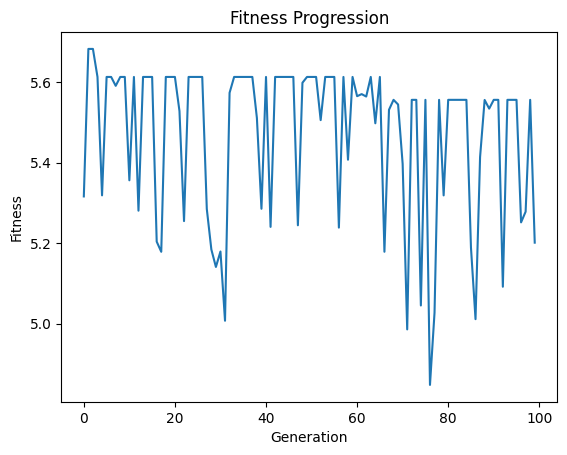

In [13]:
# Your additional code snippet for printing and sorting the results
# Define lists to store the results
volume_L_values = []
volume_C_values = []
delta_Vo_values = []
delta_IL_values = []
P_l_s1_values = []
P_l_s2_values = []
P_l_C_values = []
P_l_L_Cu_values = []
solutions = []

# Iterate over different generations
for i, (solution, fitness) in enumerate(zip(best_solutions, best_fitnesses)):
    # Calculate volume values and delta Vo for the current solution
    L = solution[0]
    C = solution[1]
    fs = solution[2]
    nearest_C, Vol_C = search_volume_capacitance(C, csv_file_capacitance)
    nearest_L, Vol_L = search_volume_inductance(L, csv_file_inductance)

    input_values = np.array([L, C, fs])
    input_values_scaled = np.zeros_like(input_values, dtype=float)
    input_values_scaled[0] = (input_values[0] - L_min) / (L_max - L_min)
    input_values_scaled[1] = (input_values[1] - C_min) / (C_max - C_min)
    input_values_scaled[2] = (input_values[2] - fsw_min) / (fsw_max - fsw_min)
    input_values_reshaped = input_values_scaled.reshape((1, -1))
    
    prediction = model.predict(input_values_reshaped, verbose=0)
    Delta_IL_percent = prediction[0][0]
    Delta_Vo_percent = prediction[0][1]
    P_l_s1 = prediction[0][2]
    P_l_s2 = prediction[0][3]
    P_l_C = prediction[0][4]
    P_l_L_Cu = prediction[0][5]
    
    # Store the volume values, delta Vo, and solution for sorting
    volume_L_values.append(Vol_L)
    volume_C_values.append(Vol_C)
    delta_Vo_values.append(Delta_Vo_percent)
    delta_IL_values.append(Delta_IL_percent)
    P_l_s1_values.append(P_l_s1)
    P_l_s2_values.append(P_l_s2)
    P_l_C_values.append(P_l_C)
    P_l_L_Cu_values.append(P_l_L_Cu)

    solutions.append((solution, fitness, Vol_L, Vol_C, Delta_Vo_percent, Delta_IL_percent, P_l_s1, P_l_s2, P_l_C, P_l_L_Cu))

# Sort the solutions based on fitness values in ascending order
sorted_solutions = sorted(solutions, key=lambda x: x[1])

# Print the sorted solutions
print("Sorted Solutions:")
for rank, (solution, fitness, vol_L, vol_C, delta_Vo, delta_IL, P_l_s1, P_l_s2, P_l_C, P_l_L_Cu) in enumerate(sorted_solutions):
    print("Rank:", rank + 1)
    print("Solution (L, C, fsw):", solution)
    print("Fitness:", fitness)
    print("Volume L:", vol_L)
    print("Volume C:", vol_C)
    print("Delta Vo:", delta_Vo)
    print("Delta IL:", delta_IL)
    print("P_l_s1: ", P_l_s1)
    print("P_l_s2: ", P_l_s2)
    print("P_l_C: ", P_l_C)
    print("P_l_L_Cu: ", P_l_L_Cu)
    print("Losses Total:", P_l_s1 + P_l_s2 + P_l_C + P_l_L_Cu)
    print()

# Plot the fitness values for each generation
plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Progression")
plt.show()


## Ranking with constraint

Sorted Solutions:
Rank: 1
Solution (L, C, fsw): [9.4700e-04 8.0000e-05 4.8347e+04]
Fitness: 5.555635
Volume L: 2.0828406321502e-06
Volume C: 3.335e-06
Delta Vo: 0.8829085
Delta IL: 0.09435923
P_l_s1:  2.0866756
P_l_s2:  2.0916026
P_l_C:  0.06638168
P_l_L_Cu:  1.3109756
Losses Total: 5.555635

Rank: 2
Solution (L, C, fsw): [9.4700e-04 8.0000e-05 4.8347e+04]
Fitness: 5.555635
Volume L: 2.0828406321502e-06
Volume C: 3.335e-06
Delta Vo: 0.8829085
Delta IL: 0.09435923
P_l_s1:  2.0866756
P_l_s2:  2.0916026
P_l_C:  0.06638168
P_l_L_Cu:  1.3109756
Losses Total: 5.555635

Rank: 3
Solution (L, C, fsw): [9.4700e-04 8.0000e-05 4.8347e+04]
Fitness: 5.555635
Volume L: 2.0828406321502e-06
Volume C: 3.335e-06
Delta Vo: 0.8829085
Delta IL: 0.09435923
P_l_s1:  2.0866756
P_l_s2:  2.0916026
P_l_C:  0.06638168
P_l_L_Cu:  1.3109756
Losses Total: 5.555635

Rank: 4
Solution (L, C, fsw): [9.4700e-04 8.0000e-05 4.8347e+04]
Fitness: 5.555635
Volume L: 2.0828406321502e-06
Volume C: 3.335e-06
Delta Vo: 0.8829085
D

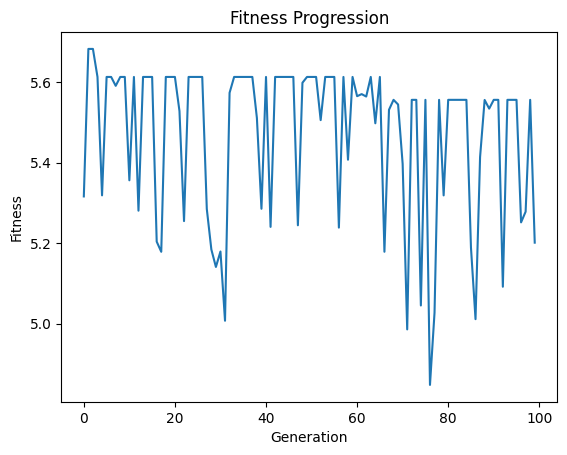

In [16]:
# Your additional code snippet for printing and sorting the results
# Define lists to store the results
volume_L_values = []
volume_C_values = []
delta_Vo_values = []
delta_IL_values = []
P_l_s1_values = []
P_l_s2_values = []
P_l_C_values = []
P_l_L_Cu_values = []
solutions = []

# Iterate over different generations
for i, (solution, fitness) in enumerate(zip(best_solutions, best_fitnesses)):
    # Calculate volume values and delta Vo for the current solution
    L = solution[0]
    C = solution[1]
    fs = solution[2]
    nearest_C, Vol_C = search_volume_capacitance(C, csv_file_capacitance)
    nearest_L, Vol_L = search_volume_inductance(L, csv_file_inductance)

    input_values = np.array([L, C, fs])
    input_values_scaled = np.zeros_like(input_values, dtype=float)
    input_values_scaled[0] = (input_values[0] - L_min) / (L_max - L_min)
    input_values_scaled[1] = (input_values[1] - C_min) / (C_max - C_min)
    input_values_scaled[2] = (input_values[2] - fsw_min) / (fsw_max - fsw_min)
    input_values_reshaped = input_values_scaled.reshape((1, -1))
    
    prediction = model.predict(input_values_reshaped, verbose=0)
    Delta_IL_percent = prediction[0][0]
    Delta_Vo_percent = prediction[0][1]
    P_l_s1 = prediction[0][2]
    P_l_s2 = prediction[0][3]
    P_l_C = prediction[0][4]
    P_l_L_Cu = prediction[0][5]
    
    # Check constraints for the current solution
    if check_constraints(solution):
        # Store the volume values, delta Vo, and solution for sorting
        volume_L_values.append(Vol_L)
        volume_C_values.append(Vol_C)
        delta_Vo_values.append(Delta_Vo_percent)
        delta_IL_values.append(Delta_IL_percent)
        P_l_s1_values.append(P_l_s1)
        P_l_s2_values.append(P_l_s2)
        P_l_C_values.append(P_l_C)
        P_l_L_Cu_values.append(P_l_L_Cu)

        solutions.append((solution, fitness, Vol_L, Vol_C, Delta_Vo_percent, Delta_IL_percent, P_l_s1, P_l_s2, P_l_C, P_l_L_Cu))

# Sort the solutions based on fitness values in ascending order
sorted_solutions = sorted(solutions, key=lambda x: x[1])

# Print the sorted solutions
print("Sorted Solutions:")
for rank, (solution, fitness, vol_L, vol_C, delta_Vo, delta_IL, P_l_s1, P_l_s2, P_l_C, P_l_L_Cu) in enumerate(sorted_solutions):
    print("Rank:", rank + 1)
    print("Solution (L, C, fsw):", solution)
    print("Fitness:", fitness)
    print("Volume L:", vol_L)
    print("Volume C:", vol_C)
    print("Delta Vo:", delta_Vo)
    print("Delta IL:", delta_IL)
    print("P_l_s1: ", P_l_s1)
    print("P_l_s2: ", P_l_s2)
    print("P_l_C: ", P_l_C)
    print("P_l_L_Cu: ", P_l_L_Cu)
    print("Losses Total:", P_l_s1 + P_l_s2 + P_l_C + P_l_L_Cu)
    print()

# Plot the fitness values for each generation
plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness Progression")
plt.show()


In [15]:
val =    [7.8700e-04, 1.6300e-04, 3.9614e+04]
pred = check_prediction(val)

P_l_s1 = pred[0][2]
P_l_s2 = pred[0][3]
P_l_C = pred[0][4]
P_l_L_Cu = pred[0][5]

# Calculate the objective function value based on the given equation
objective_value = P_l_s1 + P_l_s2 + P_l_L_Cu + P_l_C
    

print(objective_value)

5.134321
